# **Fruits 360 Image Classification**

In this project, I will be doing an Image Classification of Fruits that has over 40 classes (as required by RDAI). I will first perform basic data exploratatory on the dataset and some preprocessing before training the model. However, to improve accuracy and to prevent overfitting, I will be applying some ML techniques (listed below) that I have learnt during the course as well as my own personal study.

- Data augmentation 

Data augmentation is a technique used to artificially expand and diversify a dataset by applying various transformations to existing data, enhancing model robustness and generalization.
- Batch normalization

Batch normalization streamlines the training of deep neural networks by standardizing layer inputs within each mini-batch, resulting in a stabilized learning process and a substantial decrease in the necessary training epochs for deep network convergence.

- Weight Decay

Weight decay is employed to restrain weight magnitudes and prevent gradient explosion. By adding the L2 norm of the weights to the loss, each iteration of the network optimizes both the model weights and the loss, ensuring that the weights remain manageable and averting issues of gradient explosion.

- Gradient clipping

Gradient clipping is a technique to mitigate exploding gradients in neural networks by restricting the magnitude of the gradient. Various methods exist for computing gradient clipping, with a common approach being to rescale gradients to ensure their norm does not exceed a specified value.


# **Dataset Used**

I will be using a dataset from Kaggle (https://www.kaggle.com/moltean/fruits). Below are the few characteristics of the dataset.

Total number of images: 90483.

Training size used: 67692 images (one fruit or vegetable per image).

Test size used: 22688 images (one fruit or vegetable per image).

Total number of classes: 131 (fruits and vegetables).

Image size: 100x100 pixels.

Different species of the same fruit (apple for instance) are stored as belonging to different classes.

# **Data Pre Processing**



In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.cuda.empty_cache()

## Downloading the dataset from Kaggle

In [3]:
# ! pip install opendatasets --upgrade
import opendatasets as od

# Please type in your kaggle username and key token that you generated.
dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Skipping, found downloaded files in ".\fruits" (use force=True to force download)


Loading the dataset

In [4]:
data_dir = 'fruits/fruits-360_dataset/fruits-360/'

train_dataset = ImageFolder(data_dir + "Training", transform=ToTensor())

test_dataset = ImageFolder(data_dir + "Test", transform=ToTensor())

# Basic Data Exploratory Analysis




In [5]:
dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: fruits/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: fruits/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: ToTensor()


### Finding total number of classes


In [6]:
# Accesssing the classes
data_dir = 'fruits/fruits-360_dataset/fruits-360/'

# print(os.listdir(data_dir))
classes = os.listdir(data_dir + "Training")
print(f'Total Number of Classes {len(classes)}')
print(f'Classes Names: {classes}')

Total Number of Classes 131
Classes Names: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 

### Image Size

In [7]:
img, label = train_dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 100, 100])

Sample Image and Label

Label (numeric): 2
Label (textual): Apple Golden 1


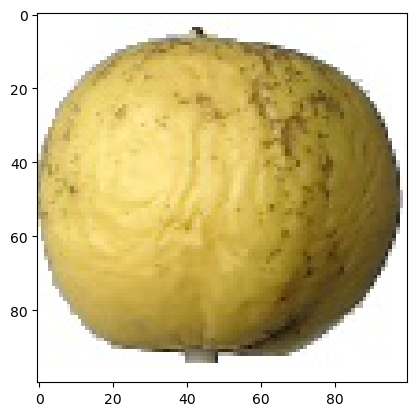

In [8]:
img, label = train_dataset[1000]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Graphical Representation of the number of images belonging to each class?

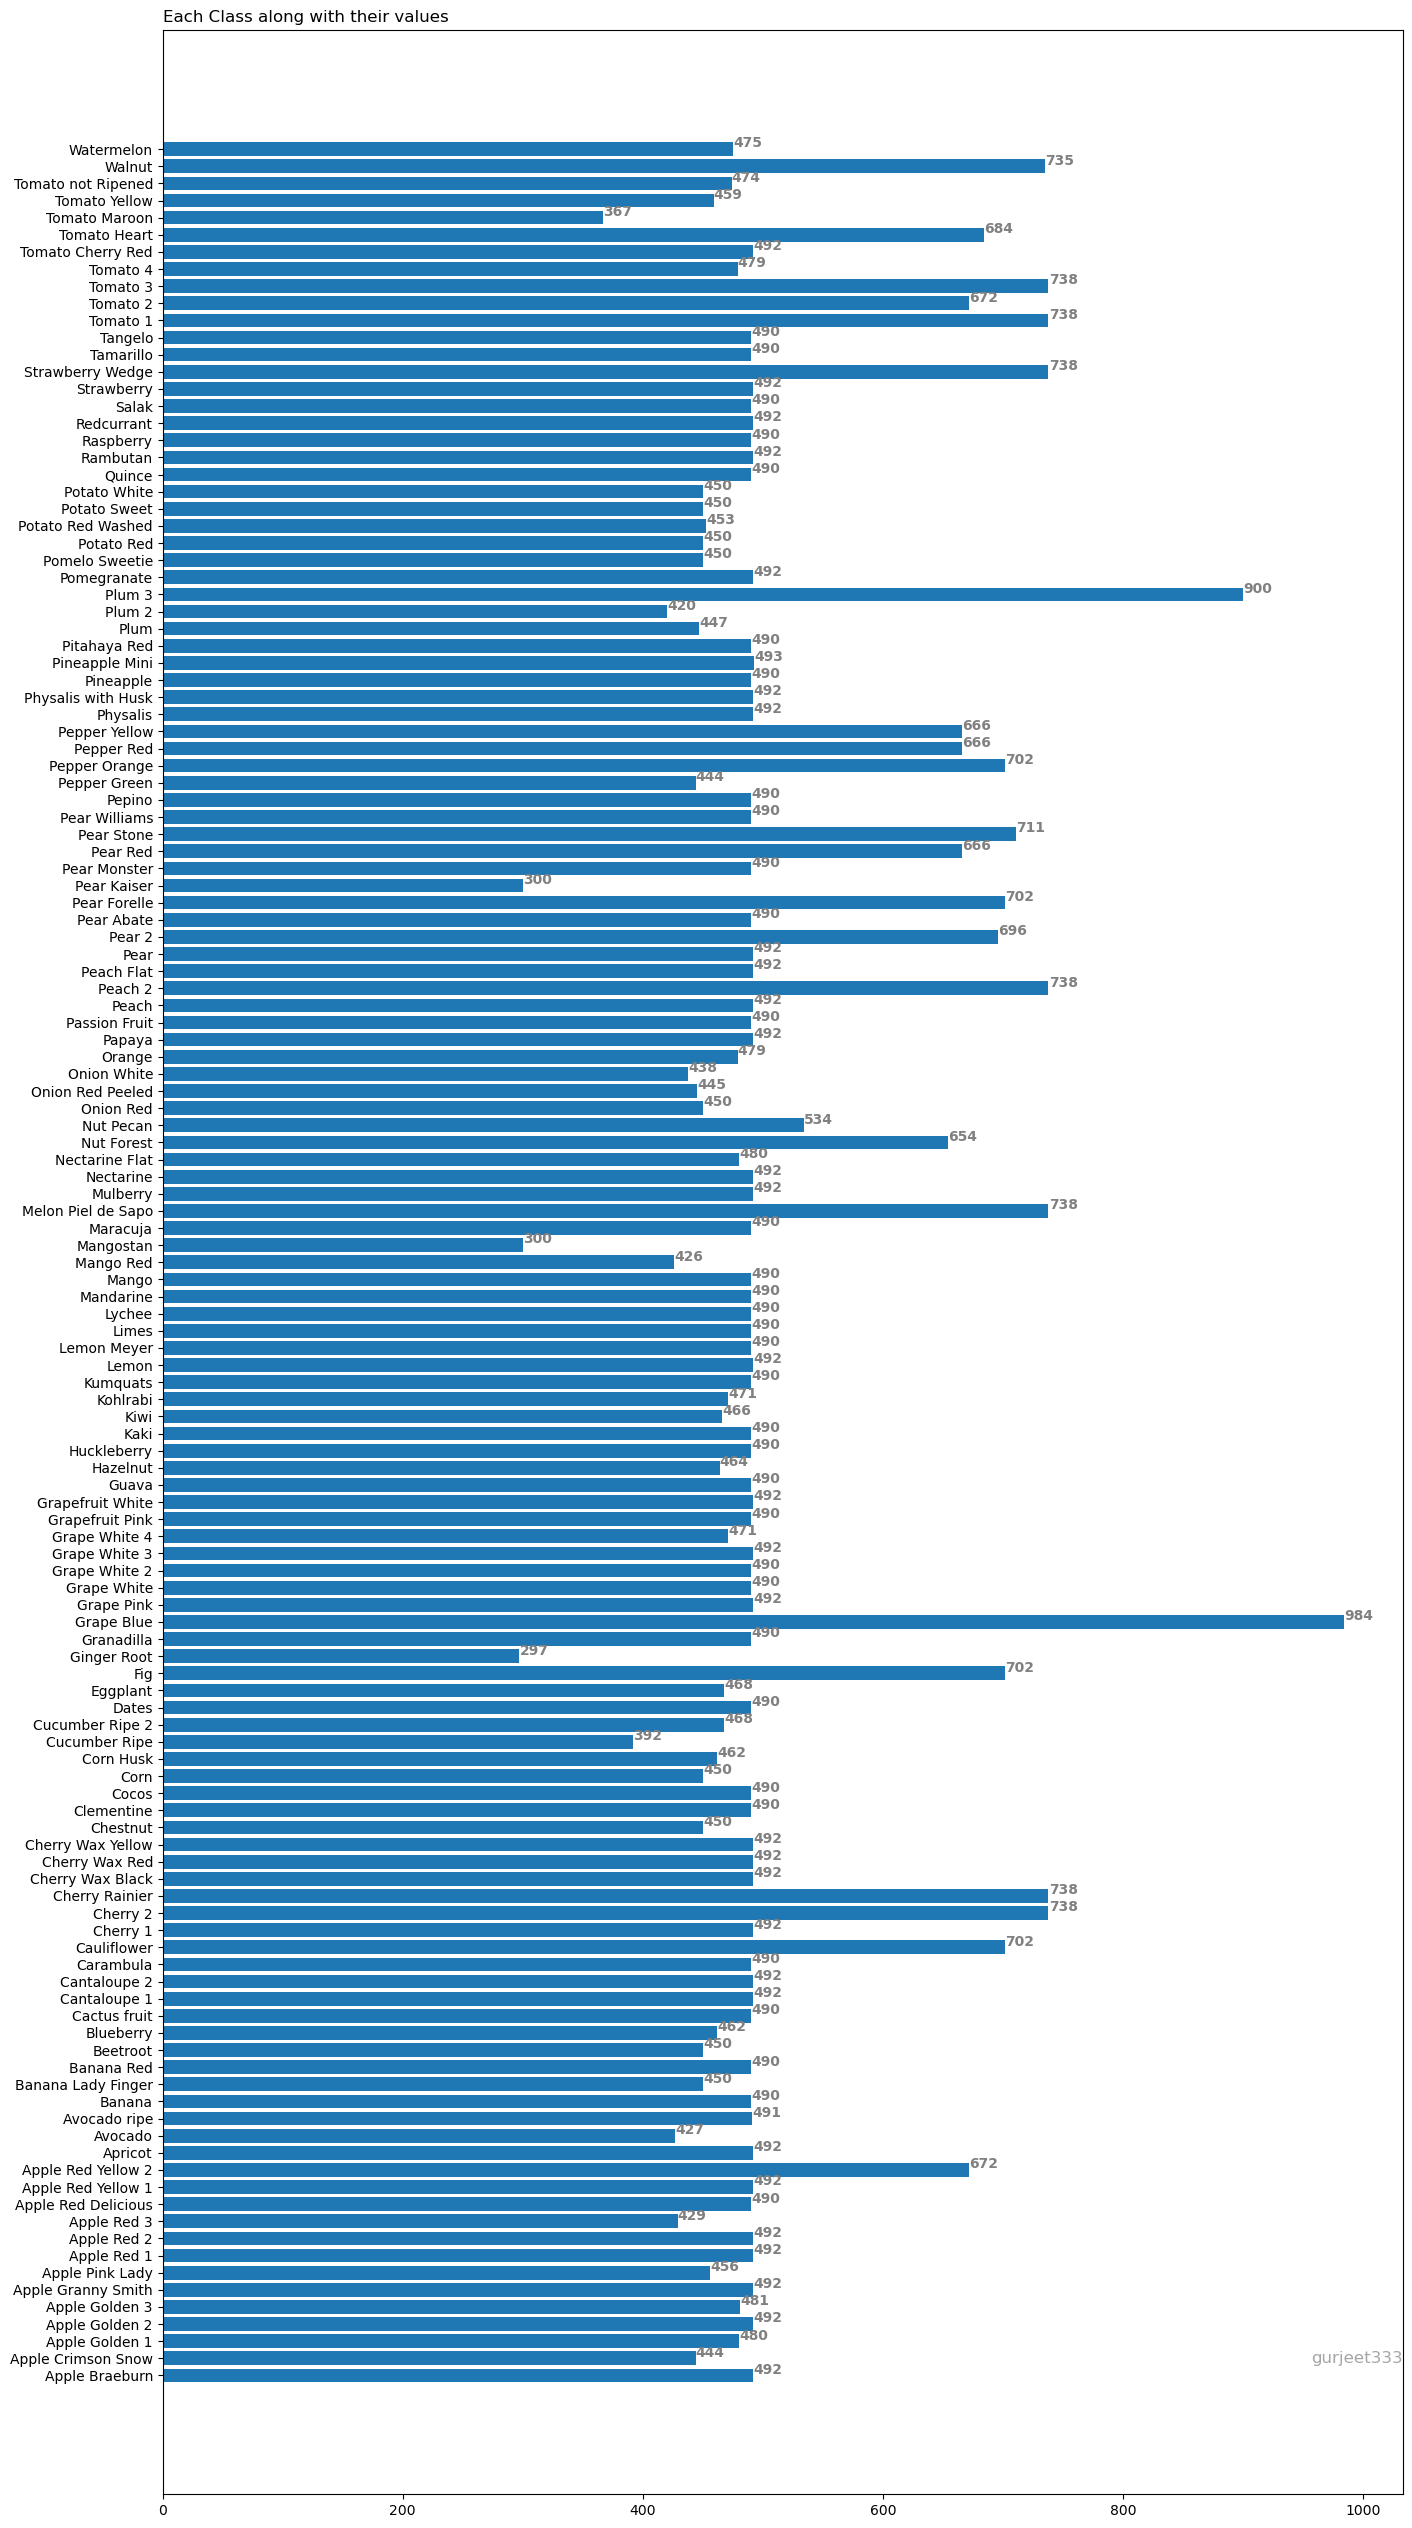

In [9]:
dataset_size = len(train_dataset)
classes = train_dataset.classes
num_classes = len(train_dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = train_dataset[i]
    img_dict[classes[label]] += 1


## Plotting classes along with images info

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize =(16, 32))

ax.barh(list(img_dict.keys()), list(img_dict.values()))



# Add Plot Title
ax.set_title('Each Class along with their values',
             loc ='left', )

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

# Add Text watermark
fig.text(0.9, 0.15, 'gurjeet333', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
plt.show()


# Data Augmentation



### Builiding data transforms

In [10]:
# Data transforms (data augmentation) that includes resizing, flipping and cropping.
train_transform = tt.Compose([
                         tt.RandomCrop(100, padding=4, padding_mode='reflect'), 
                         tt.Resize((100,100)),
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                        #  tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 

                         ])
valid_transform = tt.Compose([tt.ToTensor(), tt.Resize((100,100)),
                         ])

Please feel free to try addtional parameters like tt.RandomRotate, tt.RandomResized, tt.ColorJitter (I have added them in the code)

### Applying the transfroms to the dataset

In [11]:
dataset = ImageFolder(data_dir + "/Training", transform=train_transform)

Testing = ImageFolder(data_dir + "/Test", transform=valid_transform) # Note we don't apply transforms to the testing dataset.

### Splitting the dataset

Validation split of 0.2

In [12]:
torch.manual_seed(44)
val_size = round(len(dataset) * 0.2)
train_size = round(len(dataset) - val_size)

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(54154, 13538)

In [13]:
batch_size=400

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

[back to top](#Top)

### Visualize batch of data using helper function from Torchvision


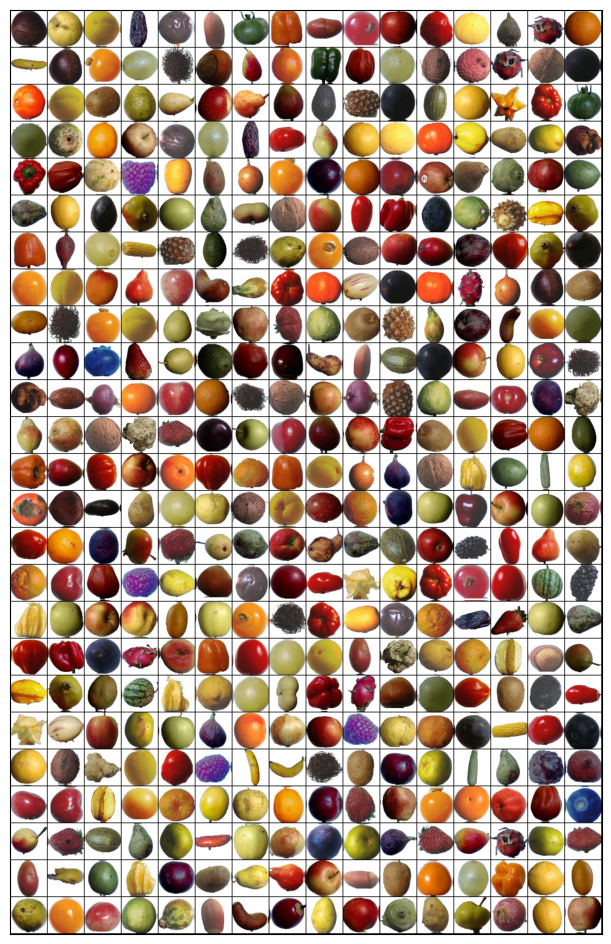

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Using GPU for training our model




In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device_gpu(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device_gpu(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device_gpu(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

cuda


## Building the Model Configuration



### Setting up general helper function for calculating accuracy and implementing loss function

In [17]:
def accuracy(outputs, labels):
    _, pred = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(pred == labels).item() / len(pred))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Model Implementation with Batch Normalization and Dropout

In [20]:
class FruitImageClassModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 16, kernel_size=2, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(5, 5),

            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1152, 131))
            # nn.Linear(10816, 131))
            # nn.Linear(64*5*5, 131))
        
    def forward(self, xb):
      return self.network(xb)

model = FruitImageClassModel()
model

FruitImageClassModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [21]:
@torch.no_grad()

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training cycle
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation part
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
# Transfering model to GPU
model = to_device_gpu(model, device)
model

FruitImageClassModel(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Model seems to be performing very poor before training. As observed below the accuracy of the model is below 1% as model tries to randomly guess the output.

In [23]:
os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(model, valid_dl)]
history


[{'val_loss': 4.876265525817871, 'val_acc': 0.0072491224855184555}]

## Training the model and Result Analysis


### Instantiating Params

In [24]:
epochs = 3
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [25]:
%%time

os.environ['WANDB_CONSOLE'] = 'off'

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.1661, val_loss: 0.9738, val_acc: 0.7372
Epoch [1], train_loss: 0.0612, val_loss: 0.0042, val_acc: 0.9990
Epoch [2], train_loss: 0.0063, val_loss: 0.0011, val_acc: 0.9999
Wall time: 2min 3s


### Accuracy vs No of epochs

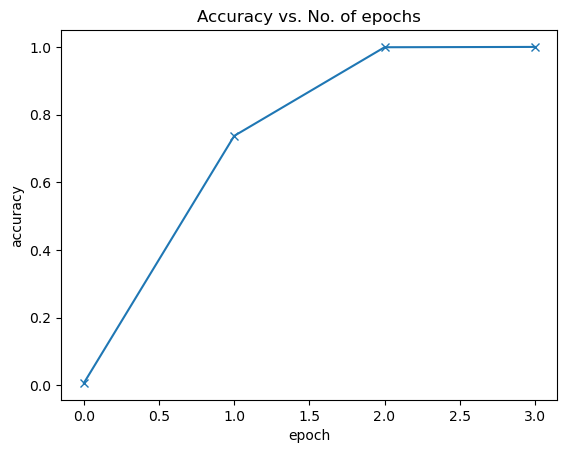

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

### Loss vs epochs

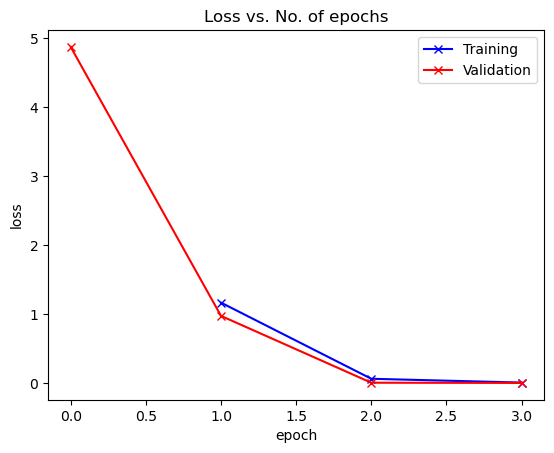

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)


As can be seen above the graph, the training and validation losses are converging instead of diverging which suggest that the model is not overfitted.

## Making Predictions Using Test Set





In [28]:
test_transform = tt.Compose([tt.Resize((100, 100)), 
                        tt.ToTensor()])

In [29]:
test_dataset = ImageFolder(data_dir + "Test", transform=test_transform)

In [30]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.05042073503136635, 'val_acc': 0.989078938961029}

In [31]:
def predict_image(img, model):
    x = to_device_gpu(img.unsqueeze(0), device)
    y = model(x)
    _, preds  = torch.max(y, dim=1)
    return dataset.classes[preds[0].item()]

Class label: Apple Braeburn Predicted: Apple Braeburn


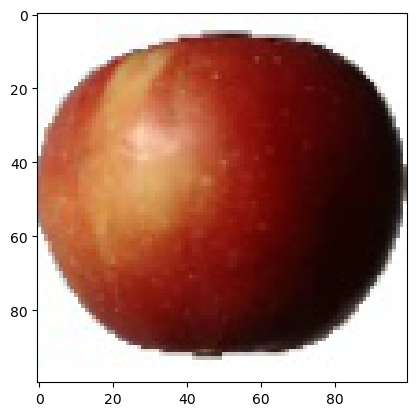

In [32]:
img, label = test_dataset[3]
plt.imshow(img.permute(1, 2, 0))
print('Class label:', dataset.classes[label], 'Predicted:', predict_image(img, model))

Class label: Carambula , Predicted: Carambula


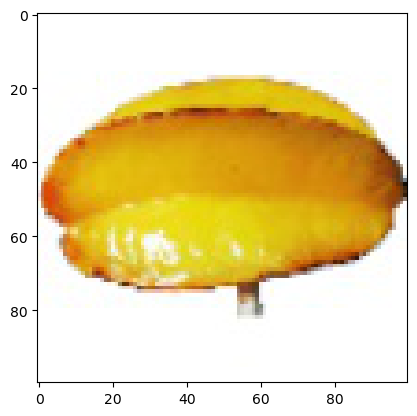

In [36]:
img, label = test_dataset[4000]
plt.imshow(img.permute(1, 2, 0))
print('Class label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Class label: Apple Red 1 , Predicted: Apple Red 1


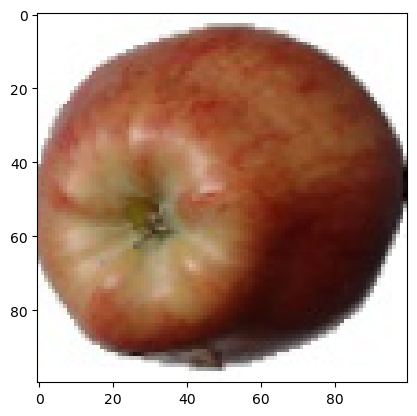

In [34]:
img, label = test_dataset[1234]
plt.imshow(img.permute(1, 2, 0))
print('Class label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Class label: Banana Red , Predicted: Banana Red


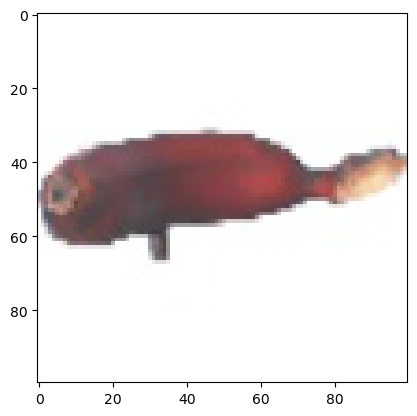

In [35]:
img, label = test_dataset[3021]
plt.imshow(img.permute(1, 2, 0))
print('Class label:', dataset.classes[label], ', Predicted:', predict_image(img, model))